16


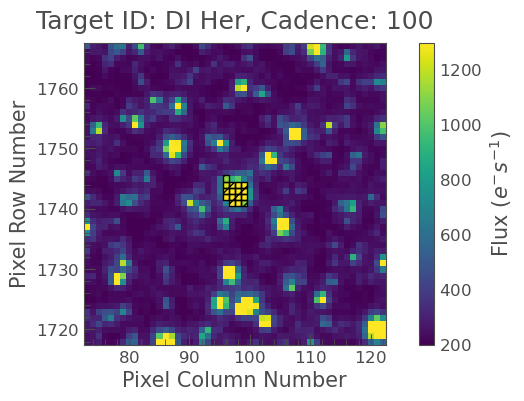

In [20]:
%matplotlib inline
import lightkurve as lk
import matplotlib.pyplot as plt
import scipy
import numpy as np
import astropy.units as u
from lightkurve import search_targetpixelfile

import starry

import pymc3 as pm
import pymc3_ext as pmx
import exoplanet

starry.config.quiet = True
starry.config.lazy = True

search_result = lk.search.search_tesscut(target='DI Her')[0:2]
search_result

lcflist = lk.search_lightcurve('DI Her')
spoc = lcflist[0].download()
tpf = search_result.download_all(cutout_size=50)
target_masks = []
pixels = []
tpfs = []
for tp in tpf[1:]:
    target_mask = tp.create_threshold_mask(threshold=15, reference_pixel='center')
    target_masks.append(target_mask)
    n_target_pixels = target_mask.sum()
    pixels.append(n_target_pixels)
    print(n_target_pixels)
    tpfs.append(tp)
    tp.plot(aperture_mask=target_mask, mask_color='k',cadenceno=100);

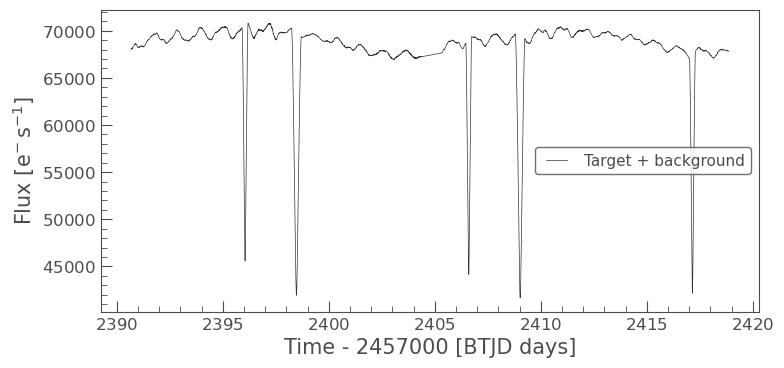

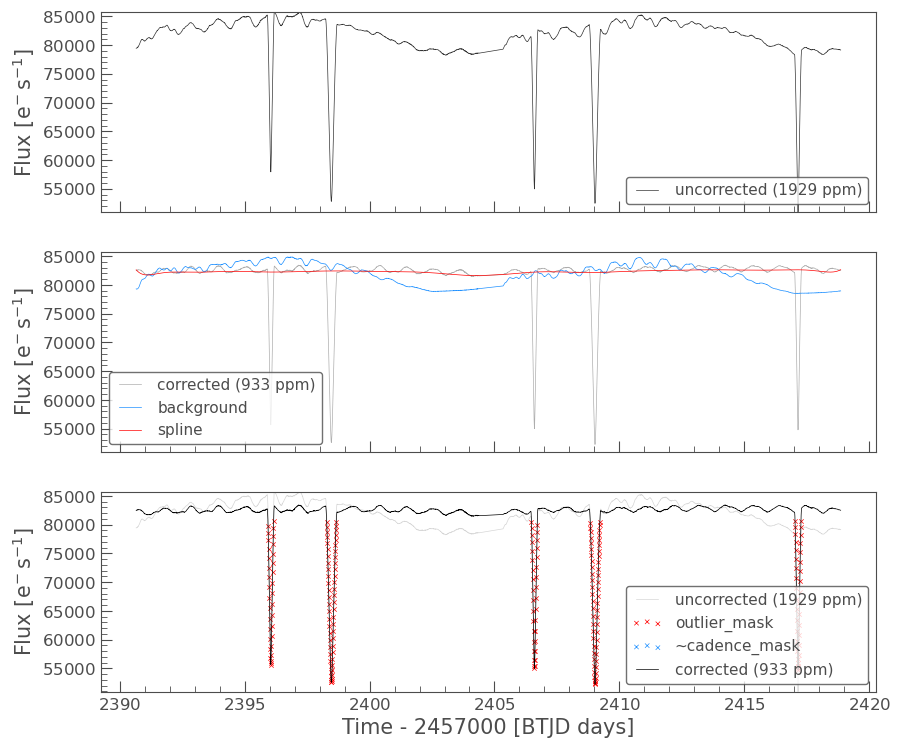

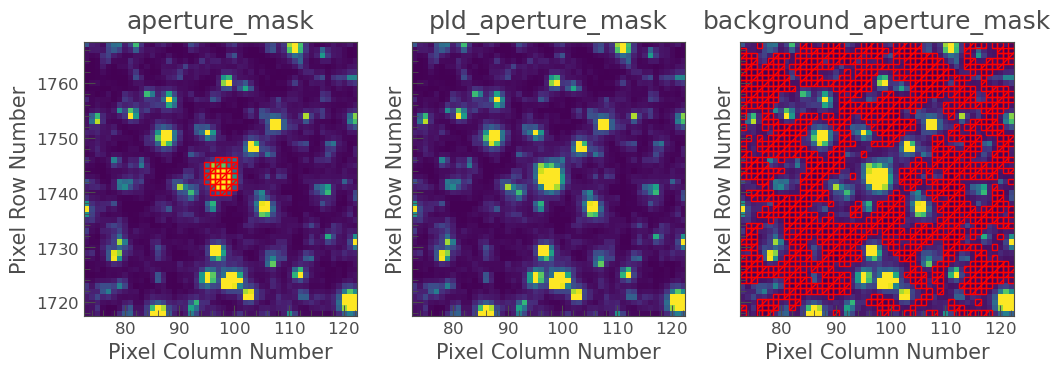

In [21]:
%matplotlib inline
from lightkurve.correctors import PLDCorrector


target_lcs = []
for i,v in enumerate(tpfs):
    uncorr_lc = v.to_lightcurve(aperture_mask=target_masks[i])
    uncorr_lc = uncorr_lc.remove_nans()
    uncorr_lc.plot(label='Target + background');

    pld = PLDCorrector(v)
    target_lcs.append(pld.correct(spline_n_knots=21))
    pld.diagnose();
    pld.diagnose_masks();

<IPython.core.display.Javascript object>


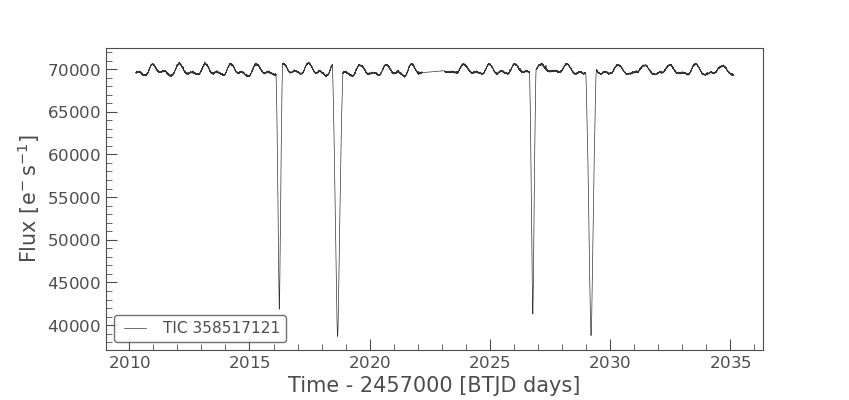

<IPython.core.display.Javascript object>


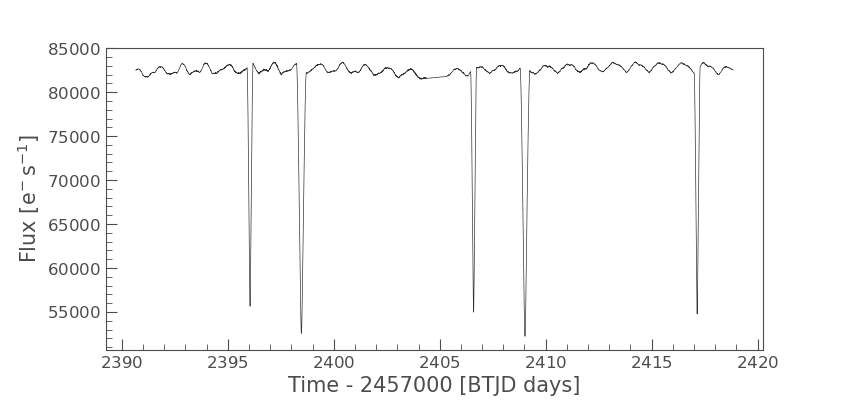

In [22]:
%matplotlib notebook
spoc.plot()
for corr_lc in target_lcs:
    corr_lc.plot()

<IPython.core.display.Javascript object>


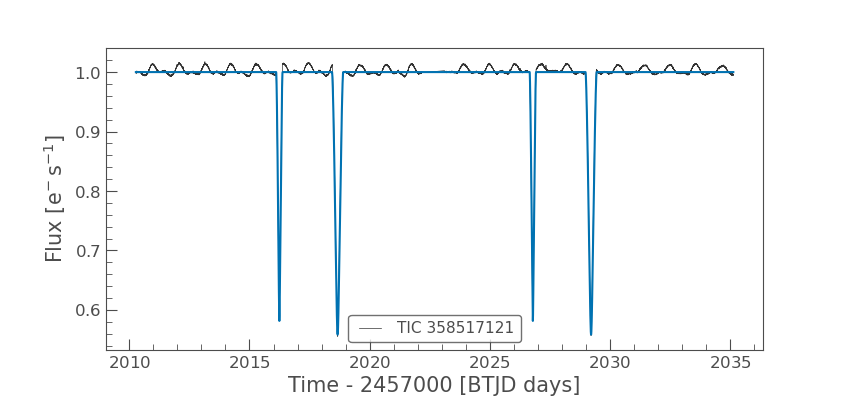

In [23]:
#create spherical star system presented in Gaudi et al. 2017
pri_map = starry.Map(udeg=2, gdeg=4) #ydeg = 2*order_approx udeg=2
pri_map[1] = 0.124
pri_map[2] = 0.262

pri = starry.Primary(pri_map, m=5.1, r=2.4,prot=1.07)
sec_map = starry.Map(udeg=2, gdeg=4)

sec_map[1] = 0.124
sec_map[2] = 0.262
sec_map.amp=0.99
sec = starry.kepler.Secondary(map=sec_map,
    m=4.4,  # mass in solar masses
    r=2.58,  # radius in solar radii
    porb=10.55004,  # orbital period in days
    inc=89.02,
    Omega=70,  # longitude of ascending node in degrees
    ecc=0.505,  # eccentricity
    w=326.6,  # longitude of pericenter in degrees
    t0=2018.6681,  # time of transit in days
)
sys = starry.System(pri, sec)

(spoc/np.median(spoc.flux.value)).plot()
time = spoc.time.value
model_flux = sys.flux(time).eval()
plt.plot(time, model_flux/np.median(model_flux));

In [24]:
#primary limb darkening
u1_m = 0.124
u1_e = 0.1
u2_m = 0.262 
u2_e = 0.1


#primary mass and radius
A_m_m = 5.1
A_m_e = 0.2
A_r_m = 2.4
A_r_e = 0.3

#primary rot period and tpole
A_prot_m =  1.07 #in days
A_omega = 0.225 #dimensionless
A_prot_e = 0.1

A_tpole_m = 17300
A_tpole_e = 800

#secondary luminosity ratio
B_amp_l = 0.6
B_amp_u = 0.8
#secondary mass and radius
B_m_m = 4.4
B_m_e = 0.2
B_r_m = 2.5
B_r_e = 0.3

#secondary tpole
B_tpole_m = 15400
B_tpole_e = 800

#secondary vsini
B_vsini_m = 100
B_vsini_e = 30

#orbital parameters
orb_inc_m = 89.02
orb_inc_e = 1.0


G_mks = 6.67e-11
Msun = 1.989e+30
Rsun = 6.95700e8

In [25]:
import theano.tensor as tt

time = spoc.time.value
flux = spoc.flux.value/np.median(spoc.flux.value)
ferr = spoc.flux_err.value/np.median(spoc.flux.value)

with pm.Model() as model:

    # These are the variables we're solving for;
    # here we're placing wide Gaussian priors on them.
    BoundedNormal = pm.Bound(pm.Normal, lower=0)
    
    A_m = BoundedNormal("A_M",mu=A_m_m,sd=A_m_e,testval=A_m_m)
    A_r = BoundedNormal("A_R",mu=A_r_m,sd=A_r_e,testval=A_r_m)
    A_inc_rad = pmx.Periodic("A inc", lower=0, upper=np.pi/2)
    A_inc = pm.Deterministic("A inc deg", A_inc_rad*180/np.pi)
    A_prot = BoundedNormal("A_prot",mu=1.07,sd=0.1,testval=1.07)
    
    pm.Potential("isotropy", tt.log(tt.sin(A_inc_rad)))
    
    u1 = BoundedNormal("u1",mu=u1_m,sd=u1_e, testval=u1_m+0.001)
    u2 = BoundedNormal("u2",mu=u2_m,sd=u2_e,testval=u2_m-0.001)
    
    
    pri_map = starry.Map(udeg=2,ydeg=4) #ydeg = 2*order_approx udeg=2
    pri_map[1] = u1
    pri_map[2] = u2
    pri_map.inc= A_inc
    
    primary = starry.Primary(pri_map, m=A_m, r=A_r,prot=A_prot)

    #spin orbit parameters
    #pm.Deterministic("inc planet", orbit.incl*180/np.pi)
    #pm.Deterministic("true spin orbit", tt.arccos(tt.cos(orbit.incl)*tt.cos(inc_s)
                                              # + tt.sin(inc_s)*tt.cos(omega_p)*tt.sin(orbit.incl))*180/np.pi)
 
    B_r = BoundedNormal("B_R",mu=B_r_m,sd=B_r_e,testval=B_r_m)
    #omega_p = pmx.Angle("Omega")
    #lambda_p = pm.Deterministic("lambda", omega_p*180/np.pi) #the projected obliquity in degrees

    sec_map = starry.Map(udeg=2,ydeg=1)
    sec_map[1] = u1
    sec_map[2] = u2
    secondary = starry.kepler.Secondary(map=sec_map,
        m=4.4,  # mass in solar masses
        r=B_r,  # radius in solar radii
        porb=BoundedNormal("period",mu=10.55004,sd=0.001, testval=10.55004),  # orbital period in days
        inc=pm.Uniform("inc orb",lower=88.90,upper=89.8, testval=89.02),
        Omega=90,  # longitude of ascending node in degrees, assume pole on
        ecc=pm.Uniform("ecc", lower=0.50, upper=0.51, testval=0.505),  # eccentricity
        w=pm.Uniform("long periastron",lower=320.6,upper=330.6, testval=326.5),  # longitude of pericenter in degrees
        t0=pm.Uniform("t0", lower=2018.4681, upper=2018.8681, testval=2018.6681),  # time of transit in days
    )
    
    system = starry.System(primary, secondary)
    
    # This is how we tell `pymc3` about our observations;
    # we are assuming they are ampally distributed about
    # the true model. This line effectively defines our
    # likelihood function.
    #pm.Normal("obs", flux_model, sd=tt.sqrt(tt.exp(log_sigma_lc)**2), observed=flux)

In [26]:
with model:
    system.set_data(flux, C=ferr**2)

    # Prior on primary
    pri_mu = np.zeros(primary.map.Ny)
    pri_mu[0] = 1
    pri_L = np.zeros(primary.map.Ny)
    pri_L[0] = 1e-2
    pri_L[1:] = 1e-2
    primary.map.set_prior(mu=pri_mu, L=pri_L)
    
    # Prior on secondary
    sec_mu = np.zeros(secondary.map.Ny)
    sec_mu[0] = 0.9
    sec_L = np.zeros(secondary.map.Ny)
    sec_L[0] = 1e-4
    sec_L[1:] = 1e-4
    secondary.map.set_prior(mu=sec_mu, L=sec_L)


    pm.Potential("marginal", system.lnlike(t=time))

In [27]:
with model:
    map_soln = pmx.optimize()

WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: <starry._core.ops.rotation.tensordotRzGradientOp object at 0x000001C1817E2F10>.1
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: AdvancedSubtensor1.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: <starry._core.ops.rotation.tensordotRzGradientOp object at 0x000001C1817E2F10>.1
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: AdvancedSubtensor1.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: AdvancedSubtensor1.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: AdvancedSubtensor1.0
optimizing logp for variables: [t0, long periastron, ecc, inc orb, period, B_R, u2, u1, A_prot, A inc, A_R, A_M]


message: Desired error not necessarily achieved due to precision loss.
logp: -168716.1545869552 -> 19684.202051927095


In [28]:
with model:
    x = pmx.eval_in_model(system.solve(t=time)[0], point=map_soln)
    primary.map.amp = x[0]
    primary.map[1:, :] = x[1 : primary.map.Ny] / primary.map.amp
    secondary.map.amp = x[primary.map.Ny]
    secondary.map[1:, :] = x[primary.map.Ny + 1 :] / secondary.map.amp
    flux_model = pmx.eval_in_model(system.flux(t=time), point=map_soln)
map_soln

{'A_M_lowerbound__': array(1.62946451),
 'A_R_lowerbound__': array(0.98037701),
 'A inc_periodic__': array([ 2.64665124, -3.60375486]),
 'A_prot_lowerbound__': array(0.07237746),
 'u1_lowerbound__': array(-2.24563293),
 'u2_lowerbound__': array(-1.84542687),
 'B_R_lowerbound__': array(0.90175301),
 'period_lowerbound__': array(2.35610737),
 'inc orb_interval__': array(-7.80484869),
 'ecc_interval__': array(-6.03338199),
 'long periastron_interval__': array(0.70181414),
 't0_interval__': array(0.10218332),
 'A_M': array(5.10114238),
 'A_R': array(2.66546096),
 'A inc': array(1.41243338),
 'A inc deg': array(80.92647135),
 'A_prot': array(1.07506106),
 'u1': array(0.10586052),
 'u2': array(0.15795788),
 'B_R': array(2.46391859),
 'period': array(10.54980498),
 'inc orb': array(88.90036683),
 'ecc': array(0.50002392),
 'long periastron': array(327.28589867),
 't0': array(2018.67830945)}

<IPython.core.display.Javascript object>


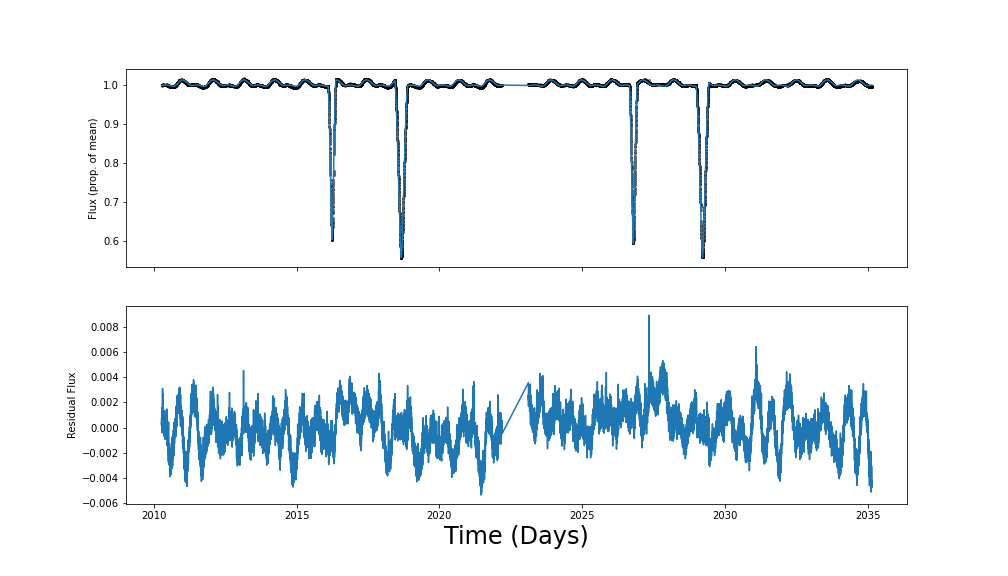

In [29]:
fig, (ax, ax2) = plt.subplots(2, figsize=(14, 8), sharex=True)

ax.plot(time, flux, "k.", alpha=0.5, ms=4, label="data")
ax.plot(time, flux_model, "C0", label="MAP")

ax2.plot(time, flux - flux_model, "C0", label="Residual")

ax.set_ylabel('Flux (prop. of mean)'); ax2.set_ylabel('Residual Flux'); ax2.set_xlabel("Time (Days)", fontsize=24)
fig.savefig('Flux Model Fit w Residuals.png', dpi=400)

In [30]:
from astropy.timeseries import LombScargle

res_flux = flux - flux_model
days = np.linspace(0.01, 30, 10000)
freqs = 1 / days
# freqs = np.linspace(1/100, 0.45, 10000)
LS = LombScargle(time, res_flux) # initialize a Lomb-Scargle
power = LS.power(freqs) # calculate LS power 

<IPython.core.display.Javascript object>


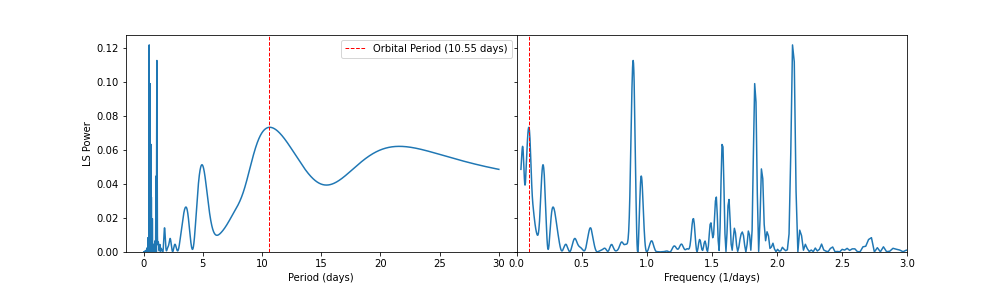

In [31]:
import matplotlib.gridspec as gridspec

fig = plt.figure(figsize=(14, 4))
gs = gridspec.GridSpec(1, 2, figure=fig, wspace=0)
ax1 = fig.add_subplot(gs[0, 0])
ax2 = fig.add_subplot(gs[0, 1], yticklabels=[])


ax1.plot(1 / freqs, power)
ax1.set_xlabel('Period (days)')
ax1.set_ylabel('LS Power')
ax1.axvline(map_soln['period'], c='r', ls='--', lw=1, label=f"Orbital Period ({map_soln['period']:.2f} days)")
ax1.set_ylim(ymin=0)
ax1.legend()

ax2.plot(freqs, power)
ax2.set_xlabel('Frequency (1/days)')
ax2.set_xlim(0, 3)
ax2.axvline(1 / map_soln['period'], c='r', ls='--', lw=1, label=f"Orbital Period ({map_soln['period']:.2f} days)")

ylims = ax1.get_ylim()
ax2.set_ylim(ylims)

fig.savefig('Residuals Lomb-Scargle (Full Fit).png', dpi=400)


<IPython.core.display.Javascript object>


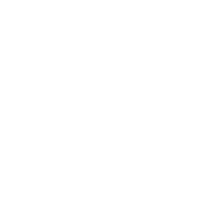

<IPython.core.display.Javascript object>


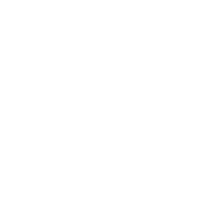

In [32]:
map = starry.Map(udeg=2,ydeg=4)
map.inc = map_soln["A inc deg"]
map.amp = x[0]
map[1:, :] = x[1 : primary.map.Ny] / map.amp
map[1] = map_soln['u1']
map[2] = map_soln['u2']
map.show(theta=np.linspace(0, 360, 50))


map = starry.Map(udeg=2,ydeg=1)
map.inc = 90
map[1] = map_soln['u1']
map[2] = map_soln['u2']
map.amp = x[primary.map.Ny]
map[1:, :] = x[primary.map.Ny + 1 :] / map.amp
map.show(theta=np.linspace(0, 360, 50))

In [33]:
with pm.Model() as model:

    # These are the variables we're solving for;
    # here we're placing wide Gaussian priors on them.
    BoundedNormal = pm.Bound(pm.Normal, lower=0)
    
    A_m = BoundedNormal("A_M",mu=A_m_m,sd=A_m_e,testval=A_m_m)
    A_r = BoundedNormal("A_R",mu=A_r_m,sd=A_r_e,testval=A_r_m)
    A_inc_rad = pmx.Periodic("A inc", lower=0, upper=np.pi/2)
    A_inc = pm.Deterministic("A inc deg", A_inc_rad*180/np.pi)
    A_prot = BoundedNormal("A_prot",mu=1.07,sd=0.1,testval=1.07)
    
    pm.Potential("isotropy", tt.log(tt.sin(A_inc_rad)))
    
    u1 = map_soln["u1"]
    u2 = map_soln["u2"]
    
    
    pri_map = starry.Map(udeg=2,ydeg=4) #ydeg = 2*order_approx udeg=2
    pri_map[1] = u1
    pri_map[2] = u2
    pri_map.inc= A_inc
    
    primary = starry.Primary(pri_map, m=A_m, r=A_r,prot=A_prot)

    #spin orbit parameters
    #pm.Deterministic("inc planet", orbit.incl*180/np.pi)
    #pm.Deterministic("true spin orbit", tt.arccos(tt.cos(orbit.incl)*tt.cos(inc_s)
                                              # + tt.sin(inc_s)*tt.cos(omega_p)*tt.sin(orbit.incl))*180/np.pi)
 
    B_r = BoundedNormal("B_R",mu=B_r_m,sd=B_r_e,testval=B_r_m)
    #omega_p = pmx.Angle("Omega")
    #lambda_p = pm.Deterministic("lambda", omega_p*180/np.pi) #the projected obliquity in degrees

    sec_map = starry.Map(udeg=2,ydeg=1)
    sec_map[1] = u1
    sec_map[2] = u2
    secondary = starry.kepler.Secondary(map=sec_map,
        m=4.4,  # mass in solar masses
        r=B_r,  # radius in solar radii
        porb=map_soln["period"],  # orbital period in days
        inc=map_soln["inc orb"],
        Omega=90,  # longitude of ascending node in degrees, assume pole on
        ecc=map_soln["ecc"],  # eccentricity
        w=map_soln["long periastron"],  # longitude of pericenter in degrees
        t0=pm.Uniform("t0", lower=2018.4681, upper=2018.8681, testval=2018.6681),  # time of transit in days
    )
    
    system = starry.System(primary, secondary)
    
    # This is how we tell `pymc3` about our observations;
    # we are assuming they are ampally distributed about
    # the true model. This line effectively defines our
    # likelihood function.
    #pm.Normal("obs", flux_model, sd=tt.sqrt(tt.exp(log_sigma_lc)**2), observed=flux)

init_vals = dict(map_soln)
for variable in ["u1", "u2", "period", "u1_lowerbound__", "u2_lowerbound__", "period_lowerbound__", "inc orb", 
                'inc orb_interval__', 'long periastron', 'long periastron_interval__', "ecc", "ecc_interval__", 
                "B_R_lowerbound__", "t0_interval__"]:
    del init_vals[variable]
init_vals

# {'A_M_lowerbound__': array(1.62946451),
#  'A_R_lowerbound__': array(0.98037701),
#  'A inc_periodic__': array([ 2.64665124, -3.60375486]),
#  'A_prot_lowerbound__': array(0.07237746),
#  'B_R_lowerbound__': array(0.90175301),
#  't0_interval__': array(0.10218332),
#  'A_M': array(5.10114238),
#  'A_R': array(2.66546096),
#  'A inc': array(1.41243338),
#  'A inc deg': array(80.92647135),
#  'A_prot': array(1.07506106),
#  'B_R': array(2.46391859),
#  't0': array(2018.67830945)}

{'A_M_lowerbound__': array(1.62946451),
 'A_R_lowerbound__': array(0.98037701),
 'A inc_periodic__': array([ 2.64665124, -3.60375486]),
 'A_prot_lowerbound__': array(0.07237746),
 'A_M': array(5.10114238),
 'A_R': array(2.66546096),
 'A inc': array(1.41243338),
 'A inc deg': array(80.92647135),
 'A_prot': array(1.07506106),
 'B_R': array(2.46391859),
 't0': array(2018.67830945)}

In [59]:
with model:
    system.set_data(flux, C=ferr**2)

    # Prior on primary
    pri_mu = np.zeros(primary.map.Ny)
    pri_mu[0] = 1
    pri_L = np.zeros(primary.map.Ny)
    pri_L[0] = 1e-2
    pri_L[1:] = 1e-2
    primary.map.set_prior(mu=pri_mu, L=pri_L)
    
    # Prior on secondary
    sec_mu = np.zeros(secondary.map.Ny)
    sec_mu[0] = 0.9
    sec_L = np.zeros(secondary.map.Ny)
    sec_L[0] = 1e-4
    sec_L[1:] = 1e-4
    secondary.map.set_prior(mu=sec_mu, L=sec_L)


    pm.Potential("marginal", system.lnlike(t=time))

In [ ]:
with model:
    trace = pmx.sample(tune=1000, draws=10000, start=init_vals, chains=2, cores=1, target_accept=0.95)

WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: <starry._core.ops.rotation.tensordotRzGradientOp object at 0x000001C19B6D6A30>.1
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: AdvancedSubtensor1.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: <starry._core.ops.rotation.tensordotRzGradientOp object at 0x000001C19B6D6A30>.1
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: AdvancedSubtensor1.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: AdvancedSubtensor1.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: AdvancedSubtensor1.0
C:\Users\ryanw\anaconda3\envs\StarryEnv\lib\site-packages\pymc3_ext\sampling\sampling.py:109: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` o

In [45]:
display(pm.summary(trace))

Got error No model on context stack. trying to find log_likelihood in translation.
C:\Users\ryanw\anaconda3\envs\StarryEnv\lib\site-packages\arviz\data\io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
A_M,5.100,0.201,4.719,5.478,0.002,0.001,17871.0,12423.0,1.0
A_R,2.400,0.301,1.848,2.974,0.003,0.002,14353.0,10355.0,1.0
A inc,1.016,0.368,0.370,1.571,0.007,0.005,2999.0,6988.0,1.0
A inc deg,58.234,21.095,21.205,89.999,0.392,0.277,2999.0,6988.0,1.0
A_prot,1.069,0.100,0.875,1.253,0.001,0.001,13668.0,9685.0,1.0
B_R,2.501,0.301,1.957,3.085,0.003,0.002,14284.0,11091.0,1.0
t0,2018.669,0.116,2018.468,2018.844,0.001,0.001,15436.0,9852.0,1.0


<IPython.core.display.Javascript object>


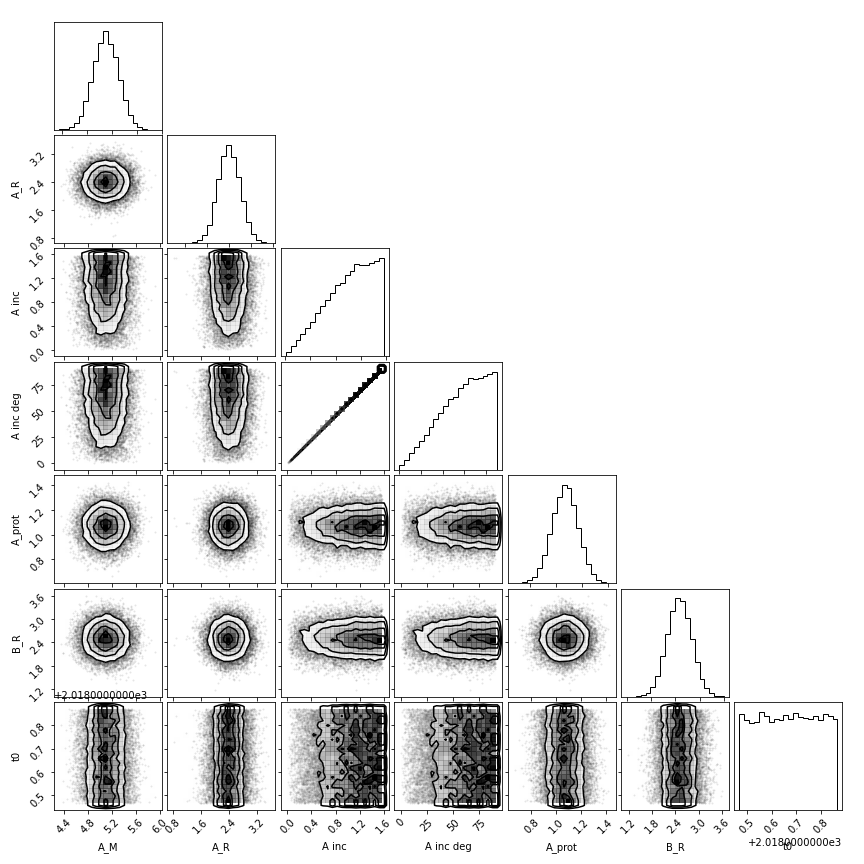

In [55]:
import corner as corner

fig = plt.figure(figsize=(12, 12))
samples = pm.trace_to_dataframe(trace)
corner.corner(samples, fig=fig)

fig.savefig('corner.png', dpi=400)

In [58]:
trace.get_sampler_stats["A_r"]

TypeError: 'method' object is not subscriptable